In [5]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import jax

from src.simulate_trace import MakeTrace, apply_noise, GaussianAmplitude, PolynomialPhase, MultiPulse, RandomPhase

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


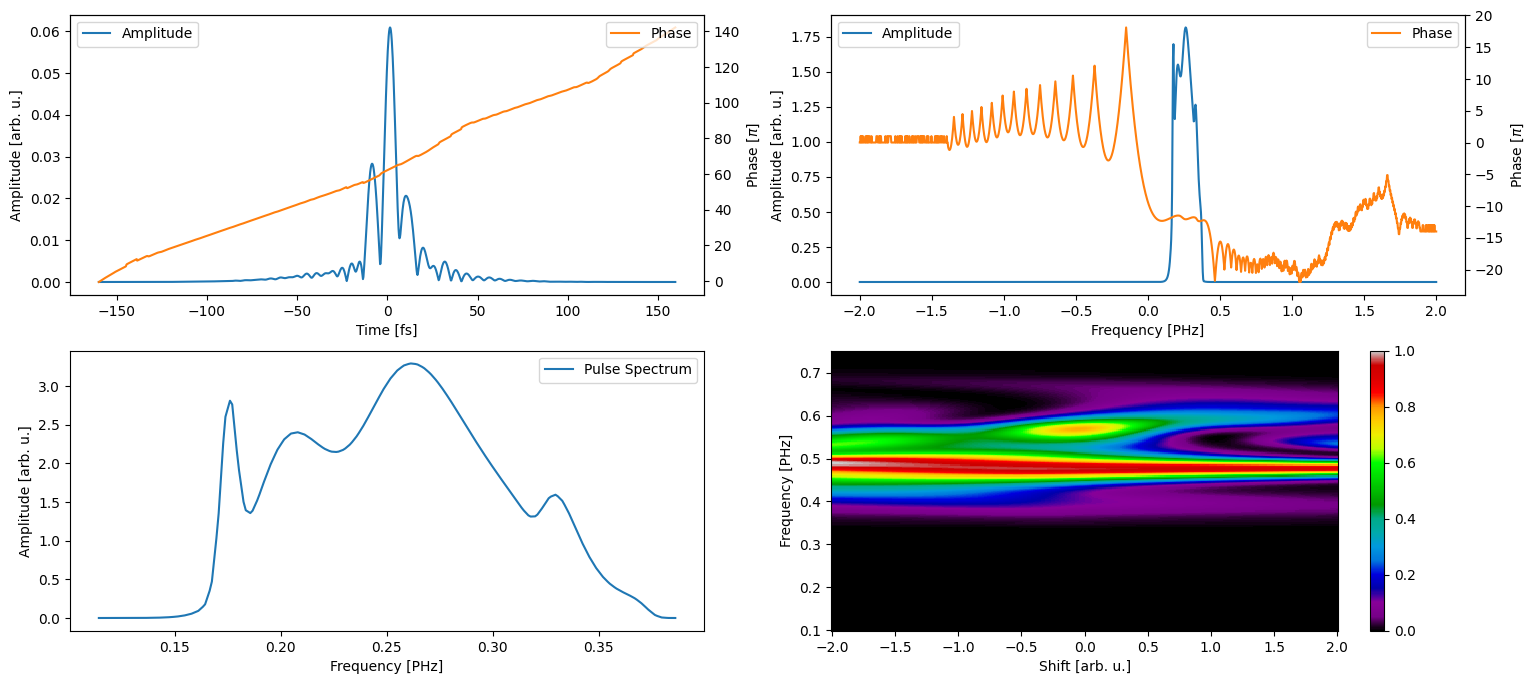

In [1]:
from src.simulate_trace import MakeTrace
from src.simulate_trace import GaussianAmplitude, RandomPhase
import jax.numpy as jnp

amp0 = GaussianAmplitude((1,1,1,0.9,0.5), (0.175,0.2,0.25,0.29,0.35), (0.01,0.05,0.1,0.1,0.05), (1,1,1,2,3))
phase0 = RandomPhase(number_of_points=4)


mp = MakeTrace(N=128*10, f_max=2)
time, pulse_t, frequency, pulse_f = mp.generate_pulse((amp0,phase0))


import refractiveindex
parameters = refractiveindex.RefractiveIndexMaterial(shelf="main", book="SiO2", page="Malitson")
z_arr = jnp.linspace(-2,2,128*2)
z_arr, frequency_trace, trace, spectra = mp.generate_chirpscan(time, frequency, pulse_t, pulse_f, "shg", 
                                                               z_arr, "material", parameters, frequency_range=(0.1,0.75))


In [9]:
import matplotlib.pyplot as plt

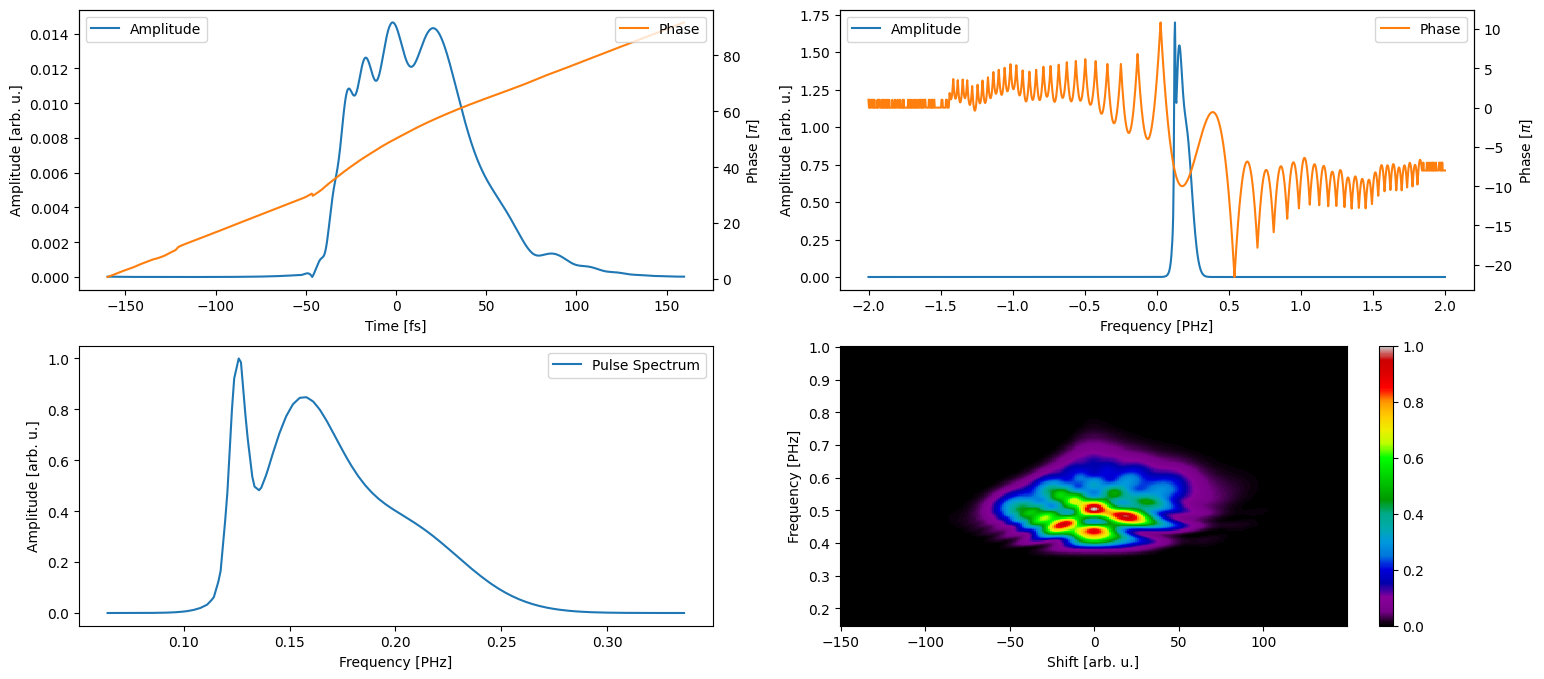

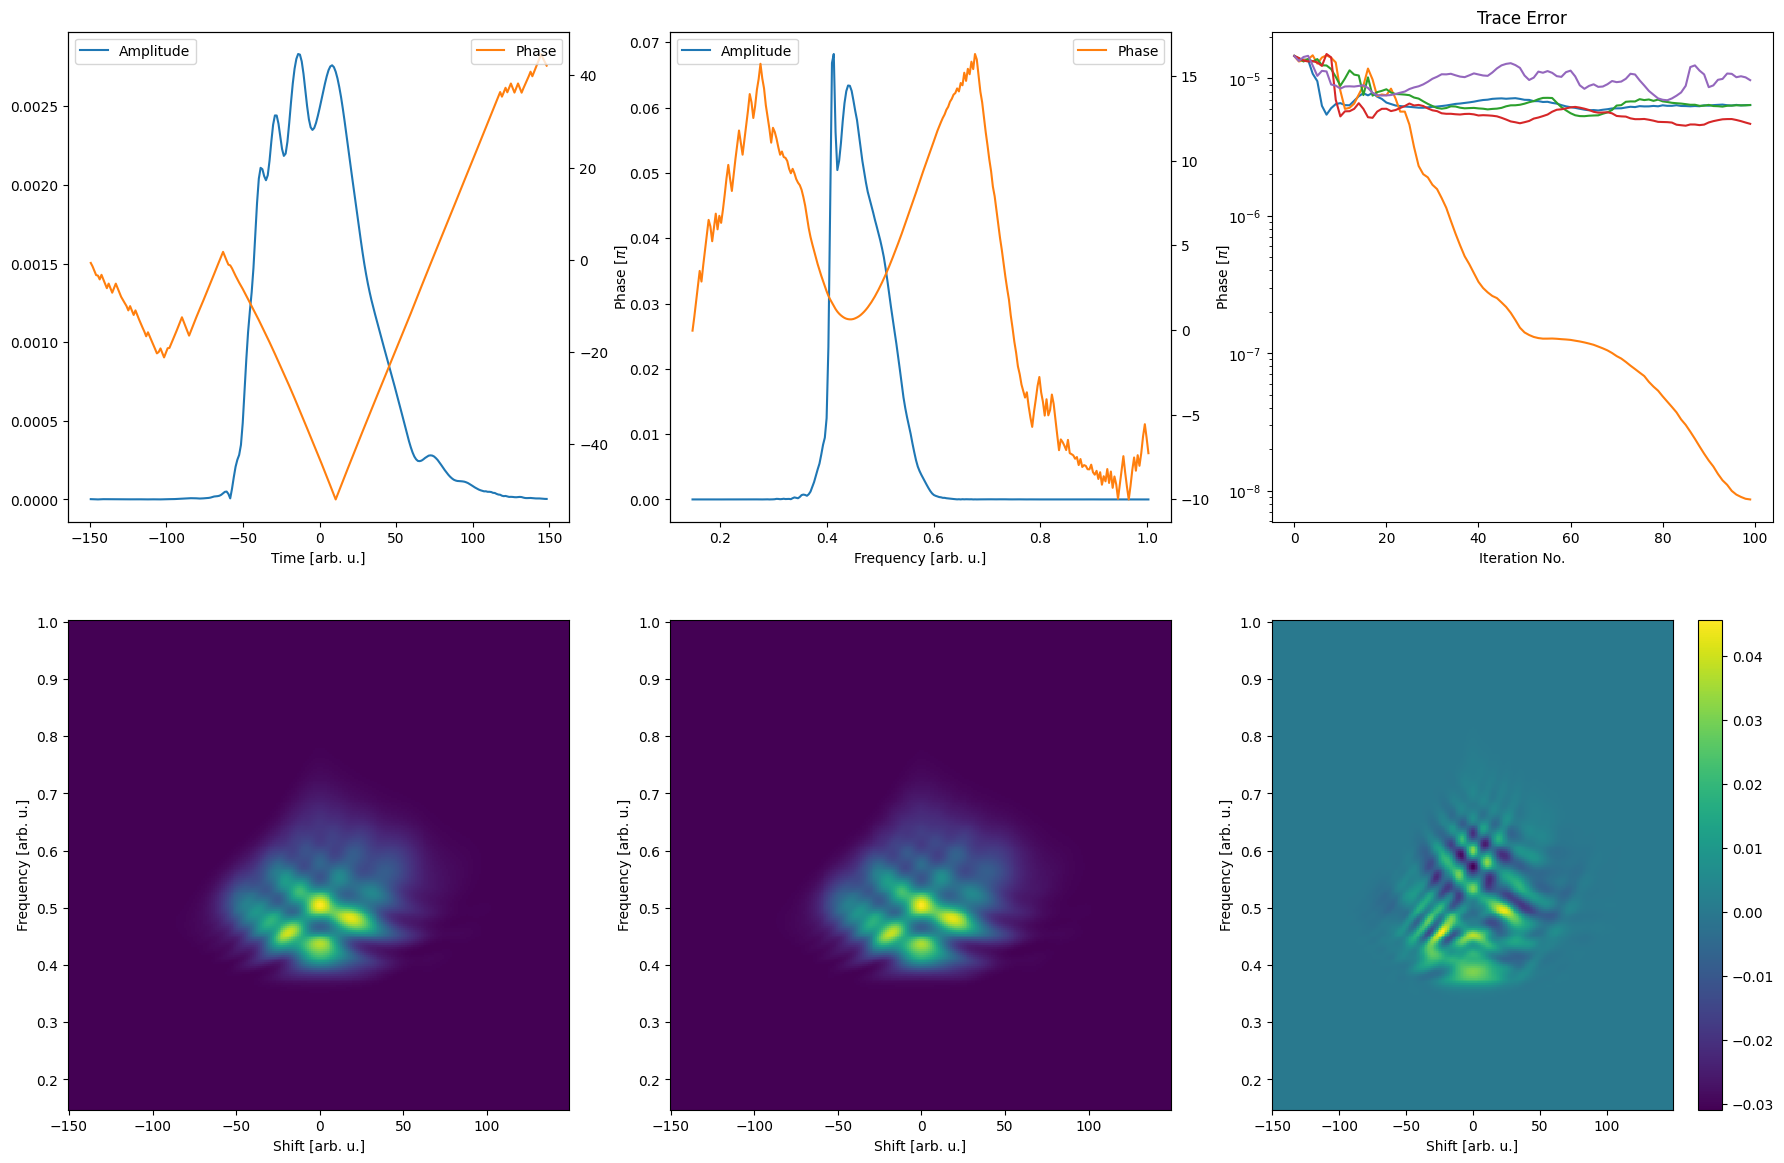

In [1]:
from src.simulate_trace import MakeTrace
from src.simulate_trace import GaussianAmplitude, PolynomialPhase
import jax.numpy as jnp

amp0 = GaussianAmplitude((1,1,1), (0.125,0.15,0.2), (0.01,0.05,0.1), (1,1,1))
phase0 = PolynomialPhase(None, (0,0,50,-25))


mp = MakeTrace(N=128*10, f_max=2)
time, pulse_t, frequency, pulse_f = mp.generate_pulse((amp0,phase0))

delay_inp = jnp.linspace(-150,150,256)
delay, frequency_trace, trace, spectra = mp.generate_frog(time, frequency, pulse_t, pulse_f, "thg", delay_inp,
                                                          interpolate_fft_conform=True)






from src.frog import CPCGPA

pcgpa = CPCGPA(delay, frequency_trace, trace, "thg")

#pcgpa.momentum(5, 0.99)
population = pcgpa.create_initial_population(5, "random")

pcgpa.constraints=True

final_result = pcgpa.run(population, 100)
pcgpa.plot_results(final_result)



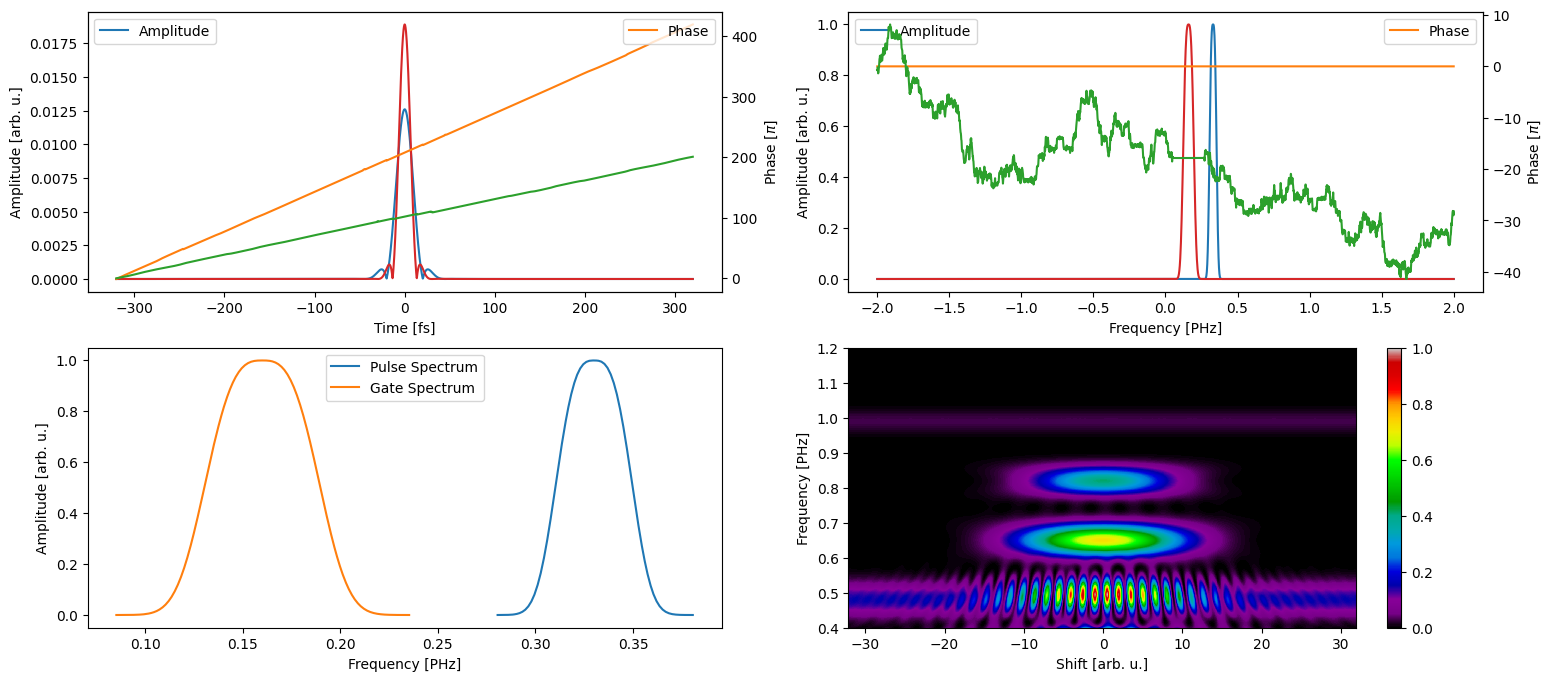

In [ ]:
pulse_maker = MakeTrace(N=128*20, Delta_f=2)

phase = PolynomialPhase(None, (0,0,0,0))
amp = GaussianAmplitude((1), (0.33), (0.05), (1.5))
time_inp, pulse_t_inp, frequency_inp, pulse_f_inp = pulse_maker.generate_pulse((amp, phase))


input_pulses = pulse_maker.pulses


# phase = PolynomialPhase(0.3, (0,0,30,0))
# amp = GaussianAmplitude((1,1), (0.225,0.2), (0.01,0.025), (1,1))
phase = PolynomialPhase(None, (0.5,0,0,0))
amp = GaussianAmplitude((1), (0.16), (0.075), (1.5))
_, _, frequency_gate, pulse_f_gate = pulse_maker.generate_pulse((amp, phase))


delay, frequency, trace, spectra=pulse_maker.generate_frog(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, "3hg", cross_correlation=True, interferometric=True,
                                                          gate=(frequency_gate, pulse_f_gate), real_fields=True, interpolate_fft_conform=False,
                                                          N=128*8, scale_time_range=0.1, plot_stuff=True, cut_off_val=0.0001, frequency_range=(0.4,1.2))

In [ ]:
trace_0 = jnp.copy(trace)

In [ ]:
trace_1 = jnp.copy(trace)

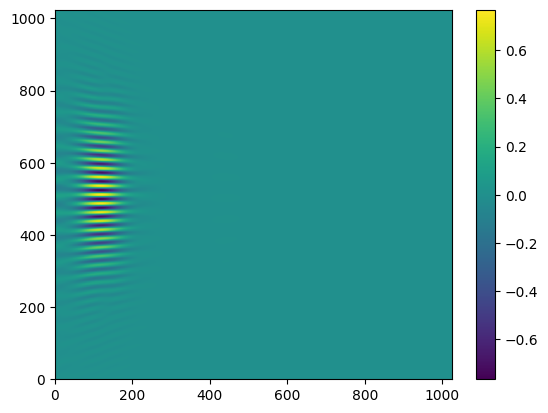

In [ ]:
plt.pcolormesh(trace_0-trace_1)
plt.colorbar()